In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 필요한 만큼만 메모리를 사용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        # 특정 GPU에 연산을 할당
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPU


In [2]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

In [3]:
rd = 'spine'

In [4]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

In [7]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [8]:
'''
Label 상태를 변경합니다.

데이터 프레임에는 일부 Nan이 포함되어 있으며 손실 및 점수를 계산할 때 
우리와 함수가 이를 무시할 수 있도록 -100으로 대체합니다.상태를 Label로 변경합니다.

'''

'\nLabel 상태를 변경합니다.\n\n데이터 프레임에는 일부 Nan이 포함되어 있으며 손실 및 점수를 계산할 때 \n우리와 함수가 이를 무시할 수 있도록 -100으로 대체합니다.상태를 Label로 변경합니다.\n\n'

In [9]:
df = df.fillna(-100)

In [10]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [12]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

In [13]:
'''
데이터 증강 정의 ¶
훈련에 사용되는 이미지의 수가 매우 적기 때문에 데이터 증강은 중요합니다. 
이 증강을 설정하는 데 도움이 되는 것은 Qishen Ha의 이 노트북을 참조하십시오.
'''

'\n데이터 증강 정의 ¶\n훈련에 사용되는 이미지의 수가 매우 적기 때문에 데이터 증강은 중요합니다. \n이 증강을 설정하는 데 도움이 되는 것은 Qishen Ha의 이 노트북을 참조하십시오.\n'

In [14]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

C:\Anaconnda3\envs\tf-gpu\lib\site-packages\pydantic\main.py:192: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9608) tensor(-0.6124) tensor(0.3377)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


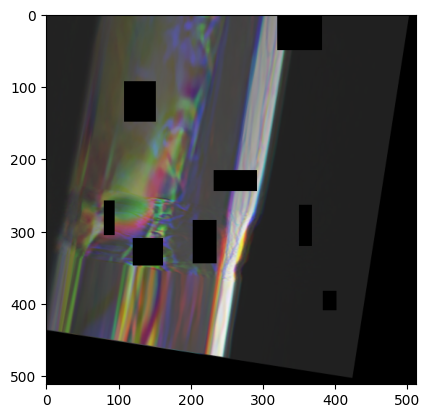

y stat: (512, 512, 3) 0.0 0.9803922 0.2027943 0.17408739

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9529) tensor(-0.4804) tensor(0.3212)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


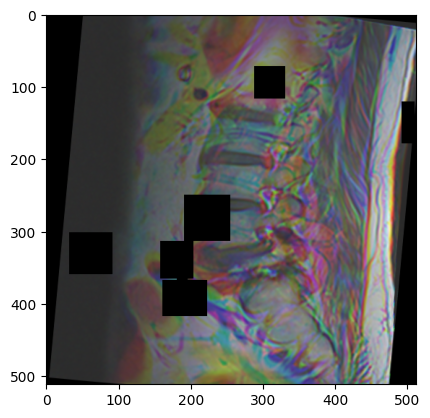

y stat: (512, 512, 3) 0.0 0.9764706 0.30179504 0.18315074

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.5529) tensor(-0.8730) tensor(0.3043)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


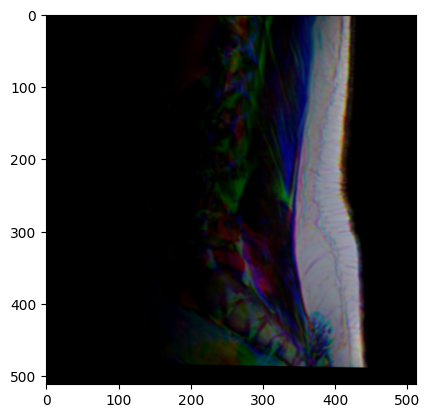

y stat: (512, 512, 3) 0.0 0.7647059 0.07843339 0.16419882

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7285) tensor(0.4041)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


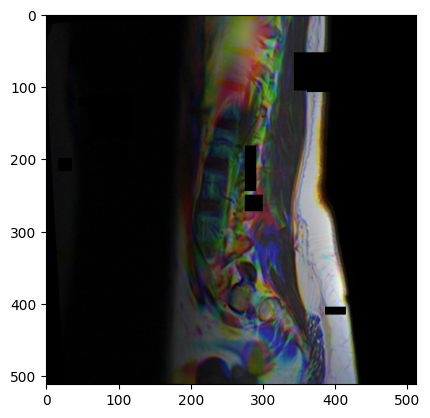

y stat: (512, 512, 3) 0.0 0.9843137 0.121246375 0.1845265

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.6863) tensor(-0.6406) tensor(0.3384)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]]) torch.Size([1, 25])


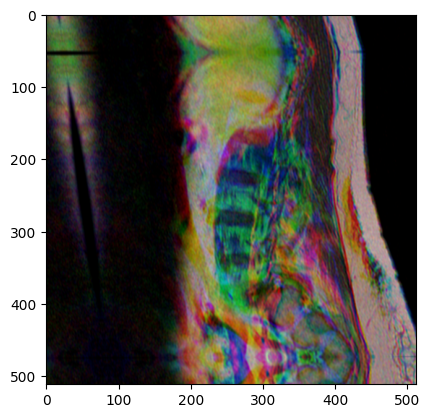

y stat: (512, 512, 3) 0.0 0.8352941 0.22415574 0.21584666



In [15]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [16]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y

In [17]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-1.1601, grad_fn=<MinBackward1>) tensor(1.2260, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.8702, grad_fn=<MinBackward1>) tensor(0.7158, grad_fn=<MaxBackward1>)


In [18]:
del m, i, out

In [ ]:
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE*2,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):  
                x = x.to(device)
                t = t.to(device)
                
                with autocast:
                    loss = 0
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS
                        
                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC
    
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)
    
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
                
                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()                    
    
        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        total_loss = 0
        y_preds = []
        labels = []
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        loss = 0
                        loss_ema = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
 
                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
                        
                        total_loss += loss.item()   
    
        val_loss = total_loss/len(valid_dl)
        
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)
        
        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        if val_loss < best_loss or val_wll < best_wll:
            
            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')                
                
            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                
            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
            
            if device!='cuda:0':
                model.to(device)
            
        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break  

C:\Anaconnda3\envs\tf-gpu\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Anaconnda3\envs\tf-gpu\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.ns_jft_in1k)


##############################
start fold0
##############################
1580 395


INFO:timm.models._hub:[timm/tf_efficientnet_b3.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 30 channel(s)


start epoch 1


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]